## Assignment

Develop your own implementations of Grid Search and Random Search. This methods should find model's hyperparameters which satisfy __minimum error value__ requirement from the variant. Use the data obtained in the first lab to train the classifiers. Type of the error is defined by the variant:

* Even variant - find such parameters for the models, so that they minimize type 1 error.
* Odd variant - find such parameters for the models, so that they minimize type 2 error.

### Upon the completion of the assignement the following must be done

1. List of hyperparameters values for _KNeighborsClassifier_ and _DecisionTreeClassifier_ classifiers.
2. Table containing f1-score, precision and recall for each class, obtained using optimal hyperparameters.
3. Consider pros and cons of using hyperparameters search methods.

---

Разработать собственную реализацию методов Grid Search и Random Search. Данные методы должны находить гиперпараметры модели, которые обеспечивают минимальное значение ошибки согласно варианту. Использовать наборы данных, полученные при выполнении лабораторной работы №1. Вид ошибки определяется в зависимости от варианта:

* Чётный номер варианта – ошибка первого рода
* Нечётный номер вариант – ошибка второго рода.

### Результаты, которые необходимо получить в итоге:

1. Значения гиперпараметров классификаторов (_KNeighborsClassifier_ и _DecisionTreeClassifier_).
2. Таблицу, содержащую значения F-меры, точности и полноты для каждого класса при использовании оптимальных значений параметров классификации.
3. Выводы о плюсах и минусах используемых методов поиска оптимальных параметров.


# Вариант №5 Борисов Дмитрий (6133-010402D)
Вид ошибки согласно варианту: ошибка второго рода.

Минимизация этого рода ошибки происходит при помощи методов Grid Search и Random Search и метрике **recall**


In [1]:
import pandas as pd
from numpy import unique, mean
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from itertools import product

## Получение данных из лабораторной работы №1

In [2]:
data = pd.read_excel("Data from Lab1.xlsx")

In [3]:
data

,x,y,label
0,1.715092,1.698583,2
1,-0.560312,0.864461,0
2,-0.691317,1.670343,0
3,-0.015075,-0.392310,0
4,0.694022,2.900271,2
...,...,...,...
2111,0.455029,-0.379949,0
2112,1.068816,1.484386,0
2113,0.869847,1.140778,1
2114,1.344564,1.453539,1


In [4]:
data, labels = data[['x', 'y']], data['label']

In [5]:
unique_labels = unique(labels)
print("Уникальные метки данных: ", ', '.join(str(label) for label in unique_labels))

Уникальные метки данных:  0, 1, 2, 3


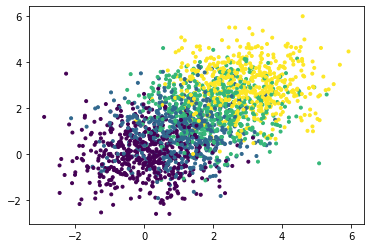

In [6]:
plt.scatter(data['x'], data['y'], c=labels, marker=".")
plt.show()

## Реализация методов GridSearchCV и RandomizedSearchCV
Данные классы реализуют методы нахождения оптимальных гиперпараметров
по одной метрике, так как используют **cross_val_score**


In [7]:
class MyGridSearch:
  def __init__(self, estimator, param_grid, scoring, cv=5):
    self.estimator = estimator
    self.param_grid = param_grid
    self.scoring = scoring
    self.best_params_ = None
    self.cv = cv

  def fit(self, X, y):
    keys = [*self.param_grid.keys()]
    best_params = None
    best_score = None

    # Построение сетки (декартово произведение) гиперпараметров
    for param in product(*self.param_grid.values()):
      param_dict = dict([(keys[i], param[i]) for i in range(len(keys))])
      self.estimator.set_params(**param_dict)
      curr_score = mean(cross_val_score(self.estimator, X, y, scoring=self.scoring, cv=self.cv))
      if best_score is None or curr_score > best_score:
        best_params = param_dict
        best_score = curr_score

    self.best_params_ = best_params
    self.best_score_ = best_score

In [8]:
class MyRandomizedSearch:
  def __init__(self, estimator, param_distributions, scoring, cv=5, n_iter=5):
    self.estimator = estimator
    self.param_distributions = param_distributions
    self.random_params = None
    self.scoring = scoring
    self.best_params_ = None
    self.best_score_ = None
    self.cv = cv
    self.n_iter = n_iter

  def fit(self, X, y):
    keys = [*self.param_distributions.keys()]
    best_params = None
    best_score = None
    random_parameters = {}

    # Генерация случайных числовых гиперпараметров
    for key in self.param_distributions.keys():
      param = self.param_distributions[key]
      if isinstance(param, tuple) and len(param) == 2 and isinstance(param[0], int) and isinstance(param[1], int):
        range_space = param[1] - param[0]
        if self.n_iter > range_space:
          self.n_iter = int(range_space)
        random_parameters[key] = sample(range(param[0], param[1] + 1), self.n_iter)
      else:
        random_parameters[key] = param

    self.random_params = random_parameters

    # Построение сетки (декартово произведение) гиперпараметров
    for param in product(*random_parameters.values()):
      param_dict = dict([(keys[i], param[i]) for i in range(len(keys))])
      self.estimator.set_params(**param_dict)
      curr_score = mean(cross_val_score(self.estimator, X, y, scoring=self.scoring, cv=self.cv))
      if best_score is None or curr_score > best_score:
        best_params = param_dict
        best_score = curr_score

    self.best_params_ = best_params
    self.best_score_ = best_score

## Подготовка данных

In [9]:
tree_model = DecisionTreeClassifier()

In [10]:
neighbors_model = KNeighborsClassifier()

In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.3)

## Инициализация возможных гиперпараметров

Возможные гиперпараметры _DecisionTree_ для **GridSearch**

In [12]:
g_max_depth = [2, 3, 4, 5, 6, 7]
g_max_leaf_nodes = [2, 3, 4, 5]
g_criterion = ['gini', 'entropy']
g_tree_parameters = {
    'max_depth': g_max_depth,
    'max_leaf_nodes': g_max_leaf_nodes,
    'criterion': g_criterion
}

Возможные гиперпараметры _KNeighbors_ для **GridSearch**

In [13]:
g_n_neighbors = range(1, 15)
g_weights = ['uniform', 'distance']
g_p = [1, 2, 3]
g_neigh_parameters = {
    'n_neighbors': g_n_neighbors,
    'weights': g_weights,
    'p': g_p
}

Возможные гиперпараметры _DesicionTree_ для **RandomSearch**

In [14]:
r_max_depth = (2, 7)
r_max_leaf_nodes = (2, 5)
r_criterion = ['gini', 'entropy']
r_tree_parameters = {
    'max_depth': r_max_depth,
    'max_leaf_nodes': r_max_leaf_nodes,
    'criterion': r_criterion
}

Возможные гиперпараметры _KNeighbors_ для **RandomSearch**

In [15]:
r_n_neighbors = (1, 15)
r_weights = ['uniform', 'distance']
r_p = (1, 4)
r_neigh_parameters = {
    'n_neighbors': r_n_neighbors,
    'weights': r_weights,
    'p': r_p
}

## Запуск реализованных методов

Запуск **GridSearch** для _DesicionTree_

In [16]:
my_g_tree_search = MyGridSearch( 
    estimator=tree_model,
    param_grid=g_tree_parameters, 
    scoring='recall_macro',
    cv=10
)

my_g_tree_search.fit(data, labels)
print("MyGridSearch for tree_model")
print("Parameters: ", my_g_tree_search.best_params_)
print("Best score: ", my_g_tree_search.best_score_)

MyGridSearch for tree_model
Parameters:  {'max_depth': 3, 'max_leaf_nodes': 5, 'criterion': 'entropy'}
Best score:  0.5780478955007258


Запуск **GridSearch** для _KNeighbors_

In [17]:
my_g_neigh_search = MyGridSearch( 
    estimator=neighbors_model,
    param_grid=g_neigh_parameters, 
    scoring='recall_macro',
    cv=10
)

my_g_neigh_search.fit(data, labels)
print("MyGridSearch for neighbors_model")
print("Parameters: ", my_g_neigh_search.best_params_)
print("Best score: ", my_g_neigh_search.best_score_)

MyGridSearch for neighbors_model
Parameters:  {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}
Best score:  0.6135522496371552


Запуск **RandomSearch** для _DesicionTree_

In [18]:
my_r_tree_search = MyRandomizedSearch(
    estimator=tree_model,
    param_distributions=r_tree_parameters,
    scoring='recall_macro',
    n_iter=5 
)
my_r_tree_search.fit(data, labels)
print("MyRandomizedSearch for tree_model")
print("Parameters: ", my_r_tree_search.best_params_)
print("Best score: ", my_r_tree_search.best_score_)

MyRandomizedSearch for tree_model
Parameters:  {'max_depth': 4, 'max_leaf_nodes': 5, 'criterion': 'entropy'}
Best score:  0.5742991913746631


Запуск **GridSearch** для _KNeighbors_

In [19]:
my_r_neigh_search = MyRandomizedSearch(
    estimator=neighbors_model,
    param_distributions=r_neigh_parameters,
    scoring='recall_macro',
    n_iter=5 
)
my_r_neigh_search.fit(data, labels)
print("MyRandomizedSearch for tree_model")
print("Parameters: ", my_r_neigh_search.best_params_)
print("Best score: ", my_r_neigh_search.best_score_)

MyRandomizedSearch for tree_model
Parameters:  {'n_neighbors': 13, 'weights': 'uniform', 'p': 4}
Best score:  0.6110826594788858


## Проверка результатов обучения

Результаты **GridSearch** для _DesicionTree_

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5)
Report for tree_model with MyGridSearch
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       152
           1       0.45      0.46      0.46       166
           2       0.46      0.26      0.33       152
           3       0.66      0.82      0.73       165

    accuracy                           0.58       635
   macro avg       0.56      0.57      0.56       635
weighted avg       0.56      0.58      0.56       635



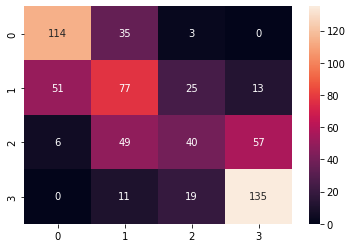

In [20]:
tree_model.set_params(**my_g_tree_search.best_params_)
tree_model.fit(Xtrain, Ytrain)
pred = tree_model.predict(Xtest)
print(tree_model)
print('Report for tree_model with MyGridSearch')
print(classification_report(Ytest, pred))
conf_mat = confusion_matrix(Ytest, pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

Результаты **GridSearch** для _KNeihgbors_

Report for neighbors_model with MyGridSearch
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       152
           1       0.50      0.45      0.47       166
           2       0.51      0.49      0.50       152
           3       0.75      0.78      0.77       165

    accuracy                           0.62       635
   macro avg       0.61      0.62      0.61       635
weighted avg       0.61      0.62      0.61       635



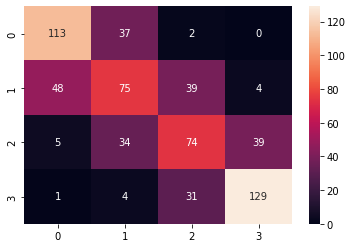

In [21]:
neighbors_model.set_params(**my_g_neigh_search.best_params_)
neighbors_model.fit(Xtrain, Ytrain)
pred = neighbors_model.predict(Xtest)
print('Report for neighbors_model with MyGridSearch')
print(classification_report(Ytest, pred))
conf_mat = confusion_matrix(Ytest, pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

Результаты **RandomSearch** для _DesicionTree_

Report for tree_model with MyRandomizedSearch
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       152
           1       0.45      0.46      0.46       166
           2       0.46      0.26      0.33       152
           3       0.66      0.82      0.73       165

    accuracy                           0.58       635
   macro avg       0.56      0.57      0.56       635
weighted avg       0.56      0.58      0.56       635



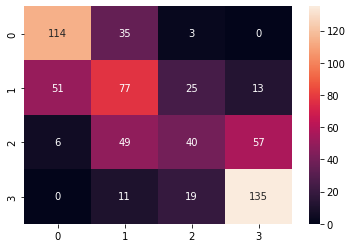

In [22]:
tree_model.set_params(**my_r_tree_search.best_params_)
tree_model.fit(Xtrain, Ytrain)
pred = tree_model.predict(Xtest)
print('Report for tree_model with MyRandomizedSearch')
print(classification_report(Ytest, pred))
conf_mat = confusion_matrix(Ytest, pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

Результаты **RandomSearch** для _KNeihgbors_

Report for neighbors_model with MyGridSearch
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       152
           1       0.50      0.47      0.49       166
           2       0.51      0.48      0.49       152
           3       0.75      0.78      0.77       165

    accuracy                           0.62       635
   macro avg       0.61      0.62      0.61       635
weighted avg       0.61      0.62      0.61       635



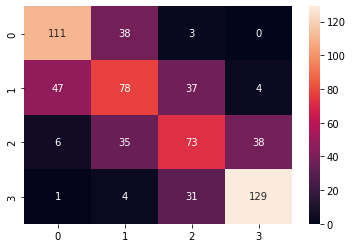

In [23]:
neighbors_model.set_params(**my_r_neigh_search.best_params_)
neighbors_model.fit(Xtrain, Ytrain)
pred = neighbors_model.predict(Xtest)
print('Report for neighbors_model with MyGridSearch')
print(classification_report(Ytest, pred))
conf_mat = confusion_matrix(Ytest, pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Conclusion

Методы **GridSearch** и **RandomSearch** выполняют одну цель - ищут оптимальные гиперпараметры для моделей сетей, однако GridSearch рассматривает пространство по переданным координатам, а RandomSearch - по случайным координатам согласно диапазону.

**GridSearch**.

 _Плюсы_: 

1.   Более высокая стабильность.

_Минусы_:

1.   Низкая производительность на больших сетках.
2.   Поиск по сетке слишком завязан на координатах, которые ему подаются.

**RandomSearch**.

_Плюсы_:

1.   Может попасть в точку пространства, которая ближе к оптимуму.
2.   При одиннаковом пространстве параметров роизводительность выше, чем у GridSearch.

_Минусы_:


1.   При малом значении *n_iter* может пропустить оптимальный набор гиперпараметров.